### CI Project notebook for demostration

#### Gautam Borgohain

In [1]:
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
pd.options.display.notebook_repr_html = True
pd.options.display.max_columns = None

In [2]:
data_unlab = pd.read_excel('/Users/gautamborgohain/Desktop/DATA/Tweets_labeled.xls')
data_unlab.head()

,Created At,ID,In Reply To,Language,Place,ReTweet Count,Sentiment,Tweet,Unnamed: 2,User Handle,DayWeek,Hour,DayYear,isSwarm
14,2016-02-11 06:49:04,697552893537357056,NaN,en,"North Region, Singapore",0,0,Inside bus 900A.. (@ SMRT Buses: Bus 900A in S...,0,nurlynnyati,3,6,42,False
18,2016-02-12 07:48:23,697930209606000000,NaN,en,"Central Region, Singapore",0,0,"Last day here, just wait for a few minutes 😢😫🚄...",0,chanichaaaaa,4,7,43,False
22,2016-02-12 07:33:39,697926502139047040,syfqhntsh,en,NaN,0,1,@syfqhntsh @SMRT_Singapore @swarmapp u today v...,1,glynisyingting,4,7,43,False
23,2016-02-12 07:33:15,697926400658029056,NaN,en,"East Region, Singapore",0,0,Otw for exam... Hope I don't flunk it lol (@ P...,0,unknownguy95,4,7,43,False
36,2016-02-12 06:34:44,697911676558012032,NaN,en,"Central Region, Singapore",5,1,RT @AdobeDocCloud: #eSign services reduced @SM...,1,MisaLan15,4,6,43,False


### Clean the tweets

Replace some of the emoticons, urls and @ symbols with more processable words

In [3]:
import re
def regexStuff(tweet):
    tweet = re.sub(r'@SMRT_singapore|@smrt_singapore|@smrt','TARGET',tweet)
    tweet = re.sub(r'@[^ ]*','NOT_TARGET',tweet)
#     tweet = re.sub('((www\.[^ ]+)|(https?://[^ ]+))', '_URL_', tweet)
#     tweet = re.sub(r'@[^ ]*','',tweet)
    tweet = re.sub('((www\.[^ ]+)|(https?://[^ ]+))', '', tweet)
    tweet = re.sub(r'[\n]','',tweet)
    tweet = re.sub('[\s]+', ' ', tweet)
    tweet = re.sub('[\.]+', '.', tweet)
    tweet = re.sub(r':-D|:D',' HAPPY',tweet)
    tweet = re.sub(r':-\)|:\)',' HAPPY',tweet)
    tweet = re.sub(r':-\(|:\(',' SAD',tweet)
    tweet = re.sub(r';-\)|;\)',' WINK',tweet)
    tweet = re.sub(r'#','HASH_',tweet)
    return tweet

In [4]:
cleanedtweets = [regexStuff(tweet) for tweet in data_unlab['Tweet']]
cleanedtweets[:20]

['Inside bus 900A. (NOT_TARGET SMRT Buses: Bus 900A in Singapore) ',
 'Last day here, just wait for a few minutes 😢😫🚄 (at TARGET) — ',
 'NOT_TARGET NOT_TARGET NOT_TARGET u today v early :")',
 "Otw for exam. Hope I don't flunk it lol (NOT_TARGET Pasir Ris MRT Station (EW1) - TARGET in Singapore) ",
 'RT NOT_TARGET HASH_eSign services reduced NOT_TARGET contract cycles from 3 weeks to as fast as 7 mins: https…',
 'To those mother fuckers so call good singapore citizen or so called the good guys and to the fucking SMRT MRTI. ',
 'Report SMRT defects via WhatsApp - DKSG HASH_whatsapp ',
 'finally ended (NOT_TARGET Bayfront MRT Interchange (CE1/DT16) - TARGET in Singapore) ',
 'NOT_TARGET NOT_TARGET NOT_TARGET report to the mrt whatsapp. Chairs stolen',
 'RT NOT_TARGET NOT_TARGET NOT_TARGET coz we pay to stand.',
 'RT NOT_TARGET If there are seats here we will all be seating. I dont understand why u do this NOT_TARGET ',
 "RT NOT_TARGET Singapore footballer hopes HASH_SLeague-SMRT partners

In [5]:
data_unlab_copy = data_unlab.copy()
data_unlab_copy['Tweet'] = cleanedtweets

### Remove the tweets which are automatically generated by the Swarm app

They start with 'I'm at' or have it in content along with an mrt station name

In [6]:
def swarmTweet(tweet):
    tweet = tweet.lower()
    if re.search(r'i\'m at [a-z ]* mrt ', tweet) or tweet.startswith('i\'m at'):
        return True
    else:
        return False
    
data_unlab_copy['isSwarm'] = [swarmTweet(tweet) for tweet in data_unlab_copy['Tweet']]
data_unlab_copy = data_unlab_copy[data_unlab_copy.isSwarm == False]
print(len(data_unlab_copy))

1276


Positive - negative - neutral distribution in the data


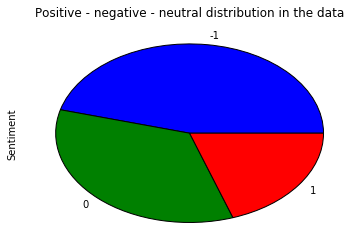

In [7]:
data_unlab_copy.Sentiment.value_counts().plot(kind = "pie",title = "Positive - negative - neutral distribution in the data")

### Some exploration on the dataset

Plot the most frequent words in the dataset

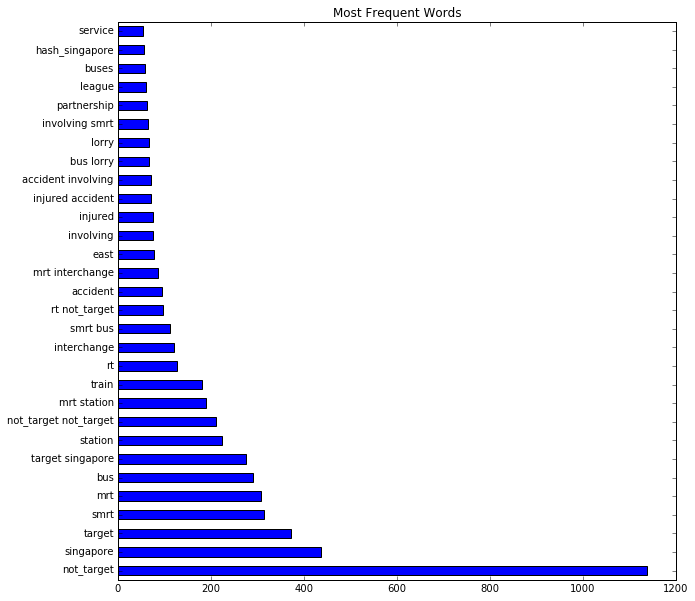

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(min_df=1,max_df=1.0,stop_words='english',lowercase=True,ngram_range=(1,2))
documentmatrix = vectorizer.fit_transform(data_unlab_copy['Tweet']).toarray()
columns = vectorizer.get_feature_names()
vectordf = pd.DataFrame(data=documentmatrix, columns=columns)
words = vectordf.sum(axis = 0)
words.sort_values(ascending=False)[:30].plot(kind = 'barh',title = 'Most Frequent Words',figsize = (10,10))

### Stanford Core NLP dependency tree features

cd stanford-corenlp-full-2015-12-09/

export CLASSPATH="`find . -name '*.jar'`" 

java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer

In [47]:
from pycorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost:9000')

In [48]:
# Sample output from the Stanford dependency parser

text = ("U guys better wake up ur idea! People pay so much for ur crappy service. People late for work now. ATSMRT")
output = nlp.annotate(text, properties={
        'annotators': 'parse,relation',
        'outputFormat': 'json'
    })
# print(output)
# print(output['sentences'][0]['basic-dependencies'])

## BOW features

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

def getBOWFeatures(frame):
    vectorizer = CountVectorizer(min_df=4,max_df = 500,stop_words='english',lowercase=True,ngram_range=(1,1))
    documentmatrix = vectorizer.fit_transform(frame['Tweet']).toarray()
    columns = vectorizer.get_feature_names()
    bowdf = pd.DataFrame(data=documentmatrix, columns=columns)
    print(len(bowdf.columns))
    return(bowdf)

## Generate target dependent features


"wi is a transitive verb and T (or any of the extended target) is its object; we generate a feature wi _arg2. "
"wi is a transitive verb and T (or any of the extended target) is its subject; we generate a feature wi_arg1 "
"wi is a intransitive verb and T (or any of the extended target) is its subject; we generate a feature wi_it_arg1"

Commented out the lines for checking target as the dependent 


Very messy code to get related data from two dictionaries- posdict(POS tags) and depdict(type dependency dict). Will optimize it later 

In [50]:
targets = ['SMRT','smrt','smrt_singapore','SMRT_SINGAPORE','train','mrt','TARGET','people','iPhone']
dependency_feats = []
for tweet in data_unlab_copy['Tweet']:
    tweet = tweet.encode('utf-8')
    output = nlp.annotate(tweet, properties={
        'annotators': 'parse,relation',
        'outputFormat': 'json'
    })
    for i in range(len(output['sentences'])):
        features = []
        posdicts = output['sentences'][i]['tokens']
        depdicts = output['sentences'][i]['basic-dependencies']
        for posdict in posdicts:
            for k in posdict:# Iterate through the POS tag dict and search for a verb 
                if(k == 'pos' and posdict[k] in ['VBG','VB','VBD','VBN','VBP','VBZ']):
                    verb = posdict['word'] #If found a verb then get the word 
                    for depdict in depdicts:
                        if depdict['governorGloss'] == verb: #Iterate through the depdict and look for dependent
        #                     if depdict['dependentGloss'] in targets:# If the verb is targeting the list of targets specified
                                if depdict['dep'] in ['obj','pobj','dobj','iobj','nmod']: #If the dependecy type is that of an object
                                    features.append(verb+'_OBJ')
                                elif depdict['dep'] in ['nsubj','dep']:# If dependency relation is a subject
                                    features.append(verb+'_SUBJ')
                        elif depdict['dependentGloss'] == verb: #Iterate through the depdict and look for governer
        #                     if depdict['governorGloss'] in targets:# If the verb is targeting the list of targets specified
                                if depdict['dep'] in ['obj','pobj','dobj','iobj','nmod']: #If the dependecy type is that of an object
                                    features.append('OBJ_'+verb)
                                elif depdict['dep'] in ['nsubj','dep']:# If dependency relation is a subject
                                    features.append('SUBJ_'+verb)
                            
                if(k == 'pos' and posdict[k] in ['JJ','JJR','JJS','NN','NNS','NNP','NNPS']):
                    adjn = posdict['word'] #If found a adjective or noun then get the word 
                    for depdict in depdicts:
                        if depdict['governorGloss'] in targets and depdict['dependentGloss'] == adjn: #Iterate through the depdict and look for dependent
                                    features.append(adjn+'_SUBJ')
                if(k == 'pos' and posdict[k] in ['RB','RBR','RBS']):
                    adverb = posdict['word']
                    for depdict in depdicts:
                        if(depdict['dependentGloss'] == adverb):
                            verb = depdict['governorGloss']
                            for depdict in depdicts:
                                if((depdict['governorGloss'] == verb or depdict['dependentGloss'] == verb) and (depdict['governorGloss'] in targets or depdict['dependentGloss'] in targets)):
                                    features.append('SUBJ_v_'+adverb)
                                    
                                
                              
    
    dependency_feats.append(' '.join(features))
print(len(dependency_feats), len(data_unlab_copy))

1276 1276


Now that we have the features, we will just use the CountVectorizer to add the features to our training data - Easier this way.

In [51]:
def getFeatureDF(feature_list):
    vectorizer = CountVectorizer()
    docmatrix = vectorizer.fit_transform(feature_list).toarray()
    columns = vectorizer.get_feature_names()
    columns = [word.upper() for word in columns]  # uppercasing to avoid conflict of in and other words
    df = pd.DataFrame(data=docmatrix, columns=columns)
    return df

In [52]:
dep_feats = getFeatureDF(dependency_feats)
dep_feats.head()

,2DAYS_OBJ,2DAYS_SUBJ,___OBJ,___SUBJ,__OBJ,__SUBJ,_OBJ,_SUBJ,ACTS_OBJ,AFFECTED_OBJ,AFFORD_OBJ,AFFORD_SUBJ,ALFRED_SUBJ,ALIGHT_OBJ,ALJUNIED_SUBJ,AM_SUBJ,ANNOUNCE_OBJ,ANNOUNCE_SUBJ,ANNOUNCED_OBJ,ANNOUNCED_SUBJ,ANNOUNCES_OBJ,ANNOUNCES_SUBJ,APPLYING_OBJ,APPLYING_SUBJ,ARE_OBJ,ARE_SUBJ,ARRESTED_OBJ,ARRIVE_OBJ,ARRIVE_SUBJ,ARRIVED_OBJ,ARRIVED_SUBJ,ASKED_SUBJ,ATTRACT_OBJ,AWAITING_OBJ,AWAITING_SUBJ,BAIL_OBJ,BAIL_SUBJ,BE_SUBJ,BECAME_SUBJ,BECOME_OBJ,BECOME_SUBJ,BEGIN_OBJ,BEGIN_SUBJ,BELIEVE_SUBJ,BELIEVED_SUBJ,BLASTING_OBJ,BLASTING_SUBJ,BLOODIES_OBJ,BOOK_OBJ,BOOKING_OBJ,BOUND_OBJ,BOUND_SUBJ,BREAKING_OBJ,BREAKING_SUBJ,BRIDGING_OBJ,BRING_OBJ,BRING_SUBJ,BROKEN_OBJ,BROKEN_SUBJ,BUCK_OBJ,BUCK_SUBJ,BUS_SUBJ,BUY_OBJ,BUY_SUBJ,CABBING_OBJ,CALL_OBJ,CALL_SUBJ,CALLED_OBJ,CARRYING_OBJ,CAUSE_OBJ,CAUSE_SUBJ,CAUSED_OBJ,CEASED_SUBJ,CHA_SUBJ,CHANGE_OBJ,CHANGE_SUBJ,CHANGING_OBJ,CHANGING_SUBJ,CHECK_OBJ,CHECK_SUBJ,CHOP_SUBJ,CIRCLE_SUBJ,CLICK_OBJ,COCKING_OBJ,COCKING_SUBJ,COLLECTED_OBJ,COLLIDED_OBJ,COLLIDED_SUBJ,COLLIDES_OBJ,COLLIDES_SUBJ,COME_OBJ,COME_SUBJ,COMING_OBJ,COMING_SUBJ,COMPLAIN_OBJ,CONFIRM_SUBJ,CONSIDER_SUBJ,CONTINUE_OBJ,CONTINUE_SUBJ,CONVERT_OBJ,CONVEYED_OBJ,COVER_OBJ,CRAWLING_OBJ,CRAWLING_SUBJ,CREATE_OBJ,CREATE_SUBJ,CROWDED_OBJ,CROWDED_SUBJ,DA_SUBJ,DEFECTS_OBJ,DEFECTS_SUBJ,DELAYED_OBJ,DELIVER_OBJ,DELIVER_SUBJ,DELIVERED_OBJ,DID_OBJ,DID_SUBJ,DIE_OBJ,DIE_SUBJ,DISAPPEAR_SUBJ,DISAPPEARED_OBJ,DISPENSE_OBJ,DISRUPTED_OBJ,DISRUPTED_SUBJ,DO_OBJ,DO_SUBJ,DOES_SUBJ,DOIN_OBJ,DOIN_SUBJ,DOING_OBJ,DOING_SUBJ,DONE_OBJ,DONE_SUBJ,DONT_SUBJ,DRIVE_OBJ,DRIVE_SUBJ,DROP_OBJ,DROP_SUBJ,DROVE_OBJ,DROVE_SUBJ,DYING_OBJ,DYING_SUBJ,EAT_OBJ,EMPHASIZE_SUBJ,END_OBJ,END_SUBJ,ENDED_OBJ,ENDED_SUBJ,ENDS_OBJ,ENDS_SUBJ,ENHANCE_OBJ,ENJOY_OBJ,ENJOY_SUBJ,EW23_SUBJ,EXPECT_OBJ,EXPECT_SUBJ,EXPECTED_OBJ,EXPLAIN_OBJ,EXPLAIN_SUBJ,EXPLORE_OBJ,EXPRESS_SUBJ,EXTEND_OBJ,FACED_SUBJ,FADED_SUBJ,FAULT_SUBJ,FEELS_SUBJ,FETCHING_OBJ,FILLED_OBJ,FIND_OBJ,FIND_SUBJ,FIX_OBJ,FIX_SUBJ,FLUNK_SUBJ,FORGOT_OBJ,FORMALISES_OBJ,FORMALISES_SUBJ,FREAKING_OBJ,FREAKING_SUBJ,FREQ_OBJ,FREQ_SUBJ,FRUSTRATED_OBJ,FRUSTRATED_SUBJ,FUCK_OBJ,FUCK_SUBJ,FUCKED_OBJ,FUCKED_SUBJ,FUCKERS_OBJ,FUCKERS_SUBJ,FUCKING_OBJ,FUCKING_SUBJ,FUTURE_SUBJ,GASPING_OBJ,GASPING_SUBJ,GET_OBJ,GET_SUBJ,GETS_SUBJ,GETTING_OBJ,GHAUT_SUBJ,GIVE_OBJ,GIVING_OBJ,GO_OBJ,GO_SUBJ,GOING_OBJ,GOING_SUBJ,GON_SUBJ,GOT_OBJ,GOT_SUBJ,GR8_SUBJ,GREETED_OBJ,GREETED_SUBJ,GUESS_OBJ,GUESS_SUBJ,GUYS,HABOURFRONT_SUBJ,HAD_OBJ,HAD_SUBJ,HALVED_OBJ,HALVED_SUBJ,HAPPEN_OBJ,HAPPEN_SUBJ,HAPPENED_OBJ,HAPPENED_SUBJ,HAPPENING_OBJ,HAS_OBJ,HAS_SUBJ,HASAN_SUBJ,HASH_PEAKHOURS_OBJ,HASH_PEAKHOURS_SUBJ,HASH_SGBREAKI_SUBJ,HASH_SLEAGUE_SUBJ,HATE_SUBJ,HAVE_OBJ,HAVE_SUBJ,HAVING_OBJ,HEADING_OBJ,HILL_SUBJ,HIRE_OBJ,HOME_SUBJ,HOPES_OBJ,HOPES_SUBJ,HOPING_SUBJ,HOSTING_OBJ,HOURS_SUBJ,HP_OBJ,HP_SUBJ,HTT_SUBJ,HTTPS_SUBJ,HURT_OBJ,IGNORE_SUBJ,IM_SUBJ,IMPROVE_OBJ,IMPROVE_SUBJ,INCLUDE_OBJ,INCLUDE_SUBJ,INCREASE_OBJ,INCREASED_OBJ,INCREASED_SUBJ,INFORM_OBJ,INJURED_OBJ,INJURED_SUBJ,INKED_OBJ,INKED_SUBJ,INSTIGATED_OBJ,INSTIGATED_SUBJ,INTERCHANGE_SUBJ,INVESTIGATING_OBJ,INVESTIGATING_SUBJ,INVOLVED_OBJ,INVOLVED_SUBJ,INVOLVING_OBJ,IS_SUBJ,JOIN_OBJ,JOINING_OBJ,JOINS_OBJ,JOINS_SUBJ,JURONG_OBJ,JURONG_SUBJ,KEEP_OBJ,KEEP_SUBJ,KEEPS_SUBJ,KESIAN_SUBJ,KIDDING_SUBJ,KILL_OBJ,KNOCKED_OBJ,KNOCKED_SUBJ,KNOW_SUBJ,LAST_OBJ,LAST_SUBJ,LATE_SUBJ,LAUNCH_OBJ,LAUNCHES_OBJ,LAUNCHES_SUBJ,LEARN_OBJ,LEAVE_OBJ,LEAVE_SUBJ,LEAVING_OBJ,LEFT_OBJ,LEFT_SUBJ,LETTING_SUBJ,LIKE_OBJ,LIKE_SUBJ,LINE_SUBJ,LIVE,LIVE_OBJ,LIVE_SUBJ,LJ_OBJ,LOOK_OBJ,LOOK_SUBJ,LOST_OBJ,LOST_SUBJ,LOVE_OBJ,LOVE_SUBJ,LOVED_SUBJ,LYING_SUBJ,M_SUBJ,MADE_OBJ,MAKE_OBJ,MAKE_SUBJ,MAKES_OBJ,MAKES_SUBJ,MARK_OBJ,MEAN_OBJ,MEAN_SUBJ,MEANS_OBJ,MEANT_OBJ,MEANT_SUBJ,MEDDLING_OBJ,MEET_OBJ,MEET_SUBJ,MEETING_OBJ,MEETING_SUBJ,MEH_OBJ,MEH_SUBJ,MET_SUBJ,MIN_SUBJ,MIND_OBJ,MISS_OBJ,MISS_SUBJ,MISSED_OBJ,MISSED_SUBJ,MISSING_OBJ,MODERNIZE_OBJ,MOVE_OBJ,MOVE_SUBJ,MOVING_OBJ,MOVING_SUBJ,MRT_SUBJ,NEED_OBJ,NEED_SUBJ,NEEDS_SUBJ,NEWS_SUBJ,NEXT_SUBJ,NOT_SUBJ,NOT_TARGET_OBJ,NOT_TARGET_SUBJ,OFFERED_OBJ,OFFICE_SUBJ,OPEN_OBJ,OPEN_SUBJ,O

## POS Tag features

Function to get the postags for the tweets. Takes the training data frame and returns a data frame with the POS features added

In [53]:
from nltk import pos_tag
from nltk import word_tokenize

def getPOStagfeatures(frame):
    tagsoftweet = []
    reg = re.compile(r'at_user|rt|TARGET,')
    count = 1
    for tweet in frame['Tweet']:
        tweet = re.sub(reg, '', tweet)  # stripping it off stuff
#         print('POS Tagging tweet', count)
        postaggedtweet = pos_tag(word_tokenize(tweet))  # this one is pos atgged..list inside list : token[1] for tag
        tags = []
        for token in postaggedtweet:
            tags.append(token[1])
        tagsoftweet.append(' '.join(tags))
        count += 1
    df = getFeatureDF(tagsoftweet)
    print('Completed POS tagging')
    return df

# Subjectivity and Hashtags

Here we use the subjectivity lexicon and get the prior polarity and the type of the words for each word in the tweet.

Thing to watch out for here is that words can have different polarity based on what part of speech it is. This function takes in the tweets data frame and returns the subjectivity features.

In [54]:
def cleantweet(tweet):
    tweet = re.sub('url|at_user|rt|\.', '', tweet)  ## removing these from the tweets
    return tweet

def getSubjectvityfeatures(frame):

    lexicon = pd.read_csv('/Users/gautamborgohain/PycharmProjects/DataScience/Twitter_target_dependent_SA/subjectivity.csv')
    tweet_tags = []
    count_tweet = 1
    for tweet in frame['Tweet']:
        tweet = cleantweet(tweet)
        typeList = []
        priorpolarityList = []
        count_word = 0  # this counter is for the pos tagging. traces the words in the tweet so that the idrect index of the tag can be accesses
#         print('Performing subjectivity analysis of Tweet ', count_tweet)
        count_tweet += 1
        for word in word_tokenize(tweet):
            result = lexicon[lexicon.word1 == word]
            if len(result) != 0:  # word is there in the lexicon
                if len(result) == 1:  # this case is handling the ones where the there is only one record of the word
                    typeList.append(result.iloc[0][0])
                    priorpolarityList.append(result.iloc[0][5])
                if len(result) > 1:  # this is if there are more than one instances of the word in the lexicon then the pos tag is checked
#                     print('Have to tag POS, Hold On!')
                    poslist = pos_tag(word_tokenize(tweet))#Tag the tweet
                    postag = poslist[count_word][1]#Using the position of the word, find the POS tag
                    if postag in ['NN', 'NNP', 'NNS',
                                  'NNPS']:  # make the POS tags to the format used by the MPQA lexicon
                        postag = 'noun'
                    elif postag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
                        postag = 'verb'
                    elif postag in ['RB', 'RBR', 'RBS']:
                        postag = 'adverb'
                    elif postag in ['JJ', 'JJR', 'JJS']:
                        postag = 'adj'
                    second_result = result[result.pos1 == postag]#get the word-postag combination from the lexicon
                    if len(second_result) != 0:  # this is to check if the pos tag that the word was tagged is there in the lexicon for that word
                        typeList.append(second_result.iloc[0][0])
                        priorpolarityList.append(second_result.iloc[0][5])

            count_word += 1

        tweet_tags.append(' '.join(typeList) + ' ' + ' '.join(priorpolarityList))

    isListEmpty = True
    for data in tweet_tags:
        if (data != " "):
            isListEmpty = False

    if(not isListEmpty):
        df = getFeatureDF(tweet_tags)
        print('Completed Subjective Analysis')
        return df

    else:
         return "No Subjectivity data found"

Some more feature (State of art)? 

- Get the hash tags in the tweets and add them as features - Polarity hash tags is usually consistent across tweets
- Get the adjectives in the tweet which has the target keywords and add them as features

In [55]:
def get_hastags(tweet):
    hash_tags = re.findall('HASH_([^ ]*)', tweet)
    return hash_tags

def getAdjectives(tweet):
    poslist = pos_tag(word_tokenize(tweet))
    adjectives = []
    for pos in poslist:
        if pos[1] in ['JJ', 'JJR', 'JJS']:
            adjectives.append(pos[0])
            
    return adjectives
            

def getTargetFeatures(frame):
    tweet_target_features = []
    for tweet in frame['Tweet']:
        tweet = cleantweet(tweet)
#         tweet = re.sub('')
        tags = get_hastags(tweet)
        keywords = ['SMRT', 'mrt', 'MRT', 'smrt', 'Singapore_MRT',"TARGET"]
        tokens = word_tokenize(tweet)
        
        targets_feature = []
        for keyword in keywords:
            if keyword in tags:  
                feature = keyword + '_hash'
                targets_feature.append(feature)
            elif keyword in tokens:
                adjectives = getAdjectives(tweet)  # This will get all the adjectives, not just one
                features = []
                for adjective in adjectives:
                    adjective = re.sub('-', '_',
                                       adjective)  # this to take care of probelesm for - like east-west/ north-south.. now east_west
                    features.append(keyword + '_' + adjective)
                feature = ' '.join(features)
                targets_feature.append(feature)

        tweet_target_features.append(' '.join(targets_feature))
#     print('features:',tweet_target_features)

    isListEmpty = True
    for data in tweet_target_features:
        if (data != ''):
            isListEmpty = False

    if(not isListEmpty):
        df = getFeatureDF(tweet_target_features)
        print("Complete target features")
        return df
    else:
         return "No Target dependant data found"

# Call the functions created and add the features

In [56]:
dfBow = getBOWFeatures(data_unlab_copy) #Prints out the number of BOW features generated

484


In [57]:
dfSubj= getSubjectvityfeatures(data_unlab_copy)
dfPOS= getPOStagfeatures(data_unlab_copy)
dfTarg = getTargetFeatures(data_unlab_copy)

Completed Subjective Analysis
Completed POS tagging
Complete target features


In [59]:
#Backup the dfs to avoid running them again and again while experimenting
dfBow_backup = dfBow.copy()
dfSubj_backup = dfSubj.copy()
dfPOS_backup = dfPOS.copy()
dfTarg = dfTarg.copy()
data_backup = data_unlab_copy.copy()
dep_feats_backup = dep_feats.copy()
#Write excel files to reuse them between sessions
dfBow.to_excel('/Users/gautamborgohain/Desktop/BOW.xlsx')
dfSubj.to_excel('/Users/gautamborgohain/Desktop/SUBJ.xlsx')
dfPOS.to_excel('/Users/gautamborgohain/Desktop/POS.xlsx')
dfTarg.to_excel('/Users/gautamborgohain/Desktop/TARG.xlsx')
dep_feats.to_excel('/Users/gautamborgohain/Desktop/DEPF.xlsx')

In [60]:
#Combine features into one data frame
data = dfBow.join(dfSubj).join(dfPOS).join(dfTarg).join(dep_feats)
import numpy as np
data_unlab_copy.index = np.arange(len(data_unlab_copy))# Need to reindex to join properly
data = data.join(data_unlab_copy['Sentiment'])

In [63]:
#Backup this as well
data.to_excel('/Users/gautamborgohain/Desktop/DATA.xlsx')

In [4]:
#Read from the backed up data when needed
import pandas as pd
data = pd.read_excel('/Users/gautamborgohain/Desktop/DATA.xlsx')

# SVM classifier for sentiment detection

The default detting of the SVM classifier is used to enable comparision with other work

In [60]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, classification_report
from sklearn.metrics import roc_curve, auc
    
def Classify(data):
    classifier = LinearSVC()
    # Seperate data to training and test set
    training_set = data.sample(frac = 0.8, random_state=1)
    print("Training set size : ", len(training_set))
    testing_set = data.loc[~data.index.isin(training_set.index)]
    print("Testing set size : ", len(testing_set),"\n")
    # Seperate the target from the df which will be used for training and testing
    target_training = training_set['Sentiment']
    target_testing = testing_set['Sentiment']
    training_set  = training_set[training_set.columns[0:(len(training_set.columns)-1)]]
    testing_set  = testing_set[testing_set.columns[0:(len(testing_set.columns)-1)]]
    
    #Train classifier
    classifier.fit(training_set, target_training)  # cross_validation.cross_val_score(classifier,training_set,training_set[config.get['target']],scoring = 'f1')
    #Predict on the training data
    predictions_training = classifier.predict(training_set)
    #Predict on the testing data
    predictions_testing = classifier.predict(testing_set)

    # Calculate the accuracy
    accuracy_training = accuracy_score(target_training, predictions_training)
    accuracy_testing = accuracy_score(target_testing, predictions_testing)
    #Print the accuracy and the crosstab of the predictions
    print("Accuracy on the training data : ", accuracy_training)
    print("Accuracy on the testing data : ", accuracy_testing, "\n")
    print("Training data Crosstab: \n", pd.crosstab(target_training, predictions_training))
    print("Testing data Crosstab: \n", pd.crosstab(target_testing, predictions_testing), "\n")
    
    #Plot the most informative features
    Negative = pd.DataFrame({'Scores':classifier.coef_[0],'Variables':training_set.columns})
    Negative.sort(columns='Scores',ascending=False)[0:10].plot(x = 'Variables', y = 'Scores',kind = "barh", legend = False,title = "Negative words")
    Positive = pd.DataFrame({'Scores':classifier.coef_[2],'Variables':training_set.columns})
    Positive.sort(columns='Scores',ascending=False)[0:10].plot(x = 'Variables', y = 'Scores',kind = "barh", legend = False, title = "Positive words")
    Neutral = pd.DataFrame({'Scores':classifier.coef_[1],'Variables':training_set.columns})
    Neutral.sort(columns='Scores',ascending=False)[0:10].plot(x = 'Variables', y = 'Scores',kind = "barh", legend = False, title = "Neutral words")
    
    #Plot the ROC curve
    
    y_score = classifier.fit(training_set, target_training).decision_function(testing_set)
    target_testting_dummies = pd.get_dummies(target_testing)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(target_testting_dummies[target_testting_dummies.columns[i]], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    plt.plot(fpr[2], tpr[2], label='Positive ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot(fpr[0], tpr[0], label='Negative ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot(fpr[1], tpr[1], label='Neutral ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    
    return classifier,target_training,target_testing,predictions_training,predictions_testing,training_set,testing_set

Training set size :  1021
Testing set size :  255 

Accuracy on the training data : 

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:36: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:38: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


 0.975514201763
Accuracy on the testing data :  0.752941176471 

Training data Crosstab: 
 col_0       -1    0    1
Sentiment               
-1         463    9    1
 0           2  346    0
 1           0   13  187
Testing data Crosstab: 
 col_0      -1   0   1
Sentiment            
-1         90  15   6
 0         16  69   7
 1          8  11  33 



/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:40: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


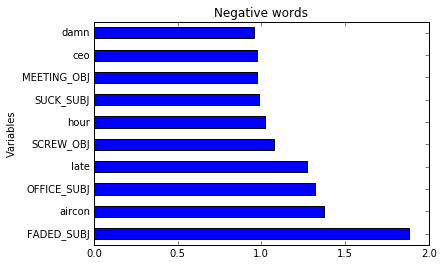

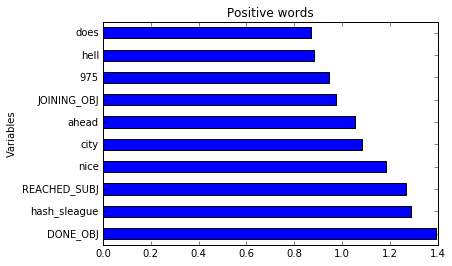

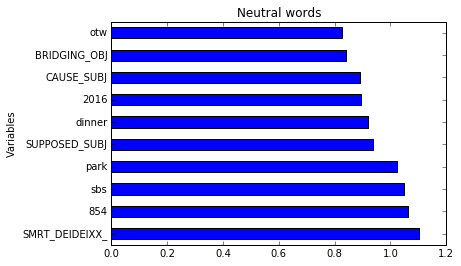

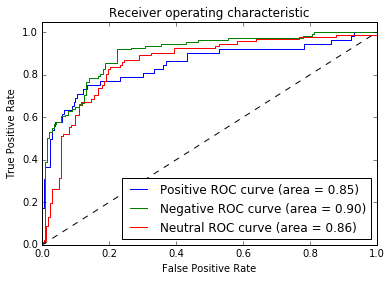

In [61]:
# Call our classifier and check accuracy!!!
classifier,target_training,target_testing,predictions_training,predictions_testing,training_set,testing_set= Classify(data)

In [58]:
print(len(target_training))
target_testting_dummies = pd.get_dummies(target_testing)
print(target_testting_dummies)
# np.array(target_testting_dummies.as_matrix())

1021
      -1   0   1
15     0   0   1
20     0   0   1
21     0   0   1
24     0   0   1
25     0   0   1
...   ..  ..  ..
1250   0   1   0
1256   0   1   0
1258   0   0   1
1271   0   1   0
1274   0   1   0

[255 rows x 3 columns]
